## What if we make the random projection hashable?

Inspired by [HashAttention: Semantic Sparsity for Faster Inference](https://arxiv.org/pdf/2412.14468) by Aditya Desai et al.
### Random hashing:

We hash $Q$ and $K$ into $B$ buckets by using a random matrix $R \in \mathbb{R}^{d \times b/2}$ and taking $\argmax([xR; −xR])$. As per the Johnson-Lindenstrauss lemma, this maps $Q$ and $K$ into a $b/2$-dimensional space in a relative-distance preserving way.

Effectively, our vector $\vec{x} \in \mathbb{R}^d$ is projected to hash vector $\vec{x}_h \in \mathbb{R}^{b/2}$, and we take its dimension with the largest component as the hash index.

### Learnable hashing:

The model can learn its own hash functions that cluster together attendant queries/keys based on semantic similarity rather than vector distance (e.g this does processing work). We want to encourage two things:
1. Downstream performance
2. Balancing loss (to prevent degenerate solutions where all q/ks are mapped to the same hash index):
    - Entropy regularization?
    - Regularization on projection matrix (L1) to prevent one dim from dominating?

In [ ]:
import torch
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             torch_dtype=torch.bfloat16,
                                             device_map="cuda:2")

In [1]:
class LearnableHash(nn.Module):
    def __init__(self, D: int, num_buckets: int, device: torch.device = "cpu", dtype: torch.dtype = torch.bfloat16):
        super().__init__()
        self.D = D
        self.num_buckets = num_buckets
        self.device = device
        self.dtype = dtype
        self.R = nn.Parameter(torch.randn(D, num_buckets // 2, device = device, dtype = dtype), requires_grad = True)

    def forward(self, x: torch.Tensor, tau: float = 1.0) -> torch.Tensor:
        proj = torch.matmul(x, self.R)
        logits = torch.cat([proj, -proj], dim=-1)
        one_hot = F.gumbel_softmax(logits, tau = tau, hard = True)
        return torch.argmax(one_hot, dim=-1)

### Experiment 1: Learnable Hashing, no balancing loss

In [ ]:
from torch import nn
from transformers.models.llama.modeling_llama import LlamaAttention, LlamaConfig, Cache, FlashAttentionKwargs, apply_rotary_pos_emb, repeat_kv
from typing import Tuple, Optional, Unpack
from tqdm import tqdm
from copy import deepcopy
from source.scfa_paper.scfa_wrapper import hash_sparse_attention

def scfa_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash: nn.Module = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    assert num_buckets % 2 == 0, "num_buckets must be even"
    q_hashes = vector_hash.forward(q).to(torch.int32).transpose(1, 2).contiguous() # (B, N, H)
    k_hashes = vector_hash.forward(k).to(torch.int32).transpose(1, 2).contiguous() # (B, N, H)
    assert q_hashes.max() < num_buckets, "q_hashes must be less than num_buckets"
    assert k_hashes.max() < num_buckets, "k_hashes must be less than num_buckets"
    assert q_hashes.min() >= 0, "q_hashes must be non-negative"
    assert k_hashes.min() >= 0, "k_hashes must be non-negative"
    scfa_q = q.transpose(1, 2).contiguous() # (B, N, H, D)
    scfa_k = k.transpose(1, 2).contiguous() # (B, N, H, D)
    scfa_v = v.transpose(1, 2).contiguous() # (B, N, H, D)
    return hash_sparse_attention(scfa_q, scfa_k, scfa_v, q_hashes, k_hashes, sm_scale).transpose(1, 2).contiguous()

class HashAttention(LlamaAttention):
    def __init__(self, config: LlamaConfig, layer_idx: int, num_buckets: int, device):
        super().__init__(config, layer_idx)
        self.vector_hash = LearnableHash(D = self.head_dim, num_buckets = num_buckets, device = device)
        self.num_buckets = num_buckets

    def forward(
        self,
        hidden_states: torch.Tensor, # (batch_size, seq_len, hidden_size)
        position_embeddings: Tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_value: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs: Unpack[FlashAttentionKwargs],
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        """
        Shapes:
        query_states: (batch_size, num_heads, seq_len, head_dim)
        key_states: (batch_size, num_heads, seq_len, head_dim)
        value_states: (batch_size, num_heads, seq_len, head_dim)
        """

        try:
            if past_key_value is not None:
                # sin and cos are specific to RoPE models; cache_position needed for the static cache
                cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
                key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

            attn_output = scfa_hash_attn(
                q = query_states,
                k = repeat_kv(key_states, self.num_key_value_groups),
                v = repeat_kv(value_states, self.num_key_value_groups),
                num_buckets = self.num_buckets,
                sm_scale = self.scaling,
                vector_hash = self.vector_hash,
            )

            attn_output = attn_output.reshape(*input_shape, -1).contiguous()
            attn_output = self.o_proj(attn_output)
        
        except Exception as e:
            print(query_states.shape, self.num_buckets)
            print(e)
        
        return attn_output, None
    
# Monkeypatch time
def monkeypatch(model, num_buckets: int, one_at_a_time: bool = False):
    n_modules_to_replace = len(list(filter(lambda x: isinstance(x, LlamaAttention), model.modules())))
    pbar = tqdm(total = n_modules_to_replace, desc = "Replacing attention modules")
    if one_at_a_time:
        pbar.disable = True    
    for name, module in model.named_modules():
        if isinstance(module, LlamaAttention):
            # Construct new module
            new_attn_module = HashAttention(config = module.config, layer_idx = module.layer_idx, num_buckets = num_buckets, device = model.device)
            new_attn_module.load_state_dict(module.state_dict(), strict = False) # random hash matrices are newly initialized
            new_attn_module.to(model.device).to(torch.bfloat16)

            # Split full name to find parent module
            parent_module = model
            parent_name_parts = name.split('.')
            child_name = parent_name_parts[-1]

            if len(parent_name_parts) > 1:
                for part in parent_name_parts[:-1]:
                    if part.isdigit(): # Handles modules in nn.Sequential or nn.ModuleList
                        parent_module = parent_module[int(part)]
                    else:
                        parent_module = getattr(parent_module, part)

            setattr(parent_module, child_name, new_attn_module)
            if one_at_a_time:
                return
            pbar.update(1)

In [5]:
import datasets

fineweb_dataset = datasets.load_dataset("HuggingFaceFW/fineweb", "sample-10BT", split="train", streaming=True)
hash_model = deepcopy(model).to(model.device)
NUM_BUCKETS = 8
tokenizer.pad_token = tokenizer.eos_token

total_steps_processed = 0
n_modules_to_replace = len(list(filter(lambda x: isinstance(x, LlamaAttention), hash_model.modules())))
while n_modules_to_replace > 0:
    print(f"{n_modules_to_replace} LlamaAttention modules remaining")
    # Patch llama attention modules into hash attention modules, one at a time
    monkeypatch(hash_model, NUM_BUCKETS, one_at_a_time = True)
    n_modules_to_replace -= 1
    hash_model.train()

    # Freeze all but the hash attention modules
    for p in hash_model.parameters():
        p.requires_grad = False
    for name, module in hash_model.named_modules():
        if isinstance(module, HashAttention):
            for param in module.parameters():
                param.requires_grad = True

    optimizer = torch.optim.AdamW(hash_model.parameters(), lr=1e-5)
    hash_model.train()

    # Training loop parameters
    num_steps = 1e3
    max_length = 512
    ema_alpha = 0.05  # EMA smoothing factor

    step = 0
    ema_loss = None
    ema_perplexity = None

    # Use streaming dataset with tqdm
    with tqdm(total=num_steps, desc="Training") as pbar:
        for example in fineweb_dataset:
            if step >= num_steps:
                total_steps_processed += step
                fineweb_dataset = fineweb_dataset.skip(total_steps_processed) # continue from where we left off
                break
                
            text = example['text']
            inputs = tokenizer(text, return_tensors="pt", max_length=max_length, 
                            truncation=True, padding=True)
            inputs = {k: v.to(hash_model.device) for k, v in inputs.items()}
            
            # Forward pass
            outputs = hash_model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            perplexity = torch.exp(loss).item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update EMA metrics
            current_loss = loss.item()
            if ema_loss is None:
                ema_loss = current_loss
                ema_perplexity = perplexity
            else:
                ema_loss = ema_alpha * current_loss + (1 - ema_alpha) * ema_loss
                ema_perplexity = ema_alpha * perplexity + (1 - ema_alpha) * ema_perplexity
            
            step += 1
            
            # Update pbar
            pbar.set_description(f"Training - Loss: {ema_loss:.4f}, PPL: {ema_perplexity:.2f}")
            pbar.update(1)

Resolving data files:   0%|          | 0/25868 [00:00<?, ?it/s]

16 LlamaAttention modules remaining


Training - Loss: 4.3298, PPL: 94.00: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.44it/s]


15 LlamaAttention modules remaining


Training - Loss: 3.9514, PPL: 70.14: 100%|██████████| 1000/1000.0 [00:53<00:00, 18.64it/s]


14 LlamaAttention modules remaining


Training - Loss: 3.8711, PPL: 53.32: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.50it/s]


13 LlamaAttention modules remaining


Training - Loss: 3.6904, PPL: 49.49: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.43it/s]


12 LlamaAttention modules remaining


Training - Loss: 3.5899, PPL: 43.79: 100%|██████████| 1000/1000.0 [00:55<00:00, 17.96it/s]


11 LlamaAttention modules remaining


Training - Loss: 3.5997, PPL: 40.12: 100%|██████████| 1000/1000.0 [00:55<00:00, 17.98it/s]


10 LlamaAttention modules remaining


Training - Loss: 3.5356, PPL: 42.00: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.32it/s]


9 LlamaAttention modules remaining


Training - Loss: 3.5259, PPL: 39.82: 100%|██████████| 1000/1000.0 [00:53<00:00, 18.72it/s]


8 LlamaAttention modules remaining


Training - Loss: 3.6034, PPL: 42.07: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.26it/s]


7 LlamaAttention modules remaining


Training - Loss: 3.5802, PPL: 44.42: 100%|██████████| 1000/1000.0 [00:55<00:00, 17.99it/s]


6 LlamaAttention modules remaining


Training - Loss: 3.4661, PPL: 36.47: 100%|██████████| 1000/1000.0 [00:58<00:00, 17.21it/s]


5 LlamaAttention modules remaining


Training - Loss: 3.5791, PPL: 42.09: 100%|██████████| 1000/1000.0 [00:56<00:00, 17.60it/s]


4 LlamaAttention modules remaining


Training - Loss: 3.5560, PPL: 42.68: 100%|██████████| 1000/1000.0 [00:59<00:00, 16.85it/s]


3 LlamaAttention modules remaining


Training - Loss: 3.4123, PPL: 35.73: 100%|██████████| 1000/1000.0 [00:59<00:00, 16.76it/s]


2 LlamaAttention modules remaining


Training - Loss: 3.5928, PPL: 45.91: 100%|██████████| 1000/1000.0 [00:59<00:00, 16.82it/s]


1 LlamaAttention modules remaining


Training - Loss: 3.4820, PPL: 38.59: 100%|██████████| 1000/1000.0 [01:00<00:00, 16.63it/s]


Resolving data files:   0%|          | 0/25868 [00:00<?, ?it/s]

Computing KL divergences between flash and hash attention models...


100%|██████████| 1000/1000 [00:46<00:00, 21.65it/s]


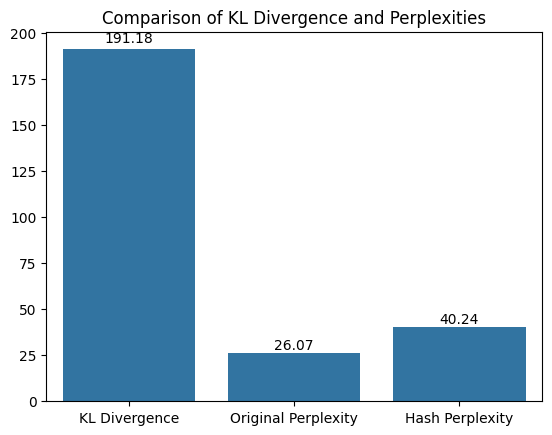

In [6]:
import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load a slice of the FineWeb dataset
fineweb_dataset = datasets.load_dataset("HuggingFaceFW/fineweb", "sample-10BT", split="train", streaming=True)
fineweb_sample = fineweb_dataset.take(1000) 
tokenizer.pad_token = tokenizer.eos_token

# Function to compute KL divergence between original and hash model
def compute_fineweb_metrics(original_model, hash_model, tokenizer, texts, max_length=512):
    import torch.nn.functional as F
    
    kl_divergences = []
    original_perplexities = []
    hash_perplexities = []
    
    for text in tqdm(texts):
        # Tokenize the text
        inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding=True)
        inputs = {k: v.to(original_model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            # Get logits from both models
            original_outputs = original_model(**inputs)
            hash_outputs = hash_model(**inputs)
            
            original_logits = original_outputs.logits
            hash_logits = hash_outputs.logits
            
            # Convert to probabilities
            original_probs = F.softmax(original_logits, dim=-1)
            hash_probs = F.softmax(hash_logits, dim=-1)
            
            # Compute KL divergence: KL(original || hash)
            kl_div = F.kl_div(hash_probs.log(), original_probs, reduction='batchmean')
            kl_divergences.append(kl_div.item())
            
            # Compute perplexities
            # Shift logits and labels for next token prediction
            shift_logits_original = original_logits[..., :-1, :].contiguous()
            shift_logits_hash = hash_logits[..., :-1, :].contiguous()
            shift_labels = inputs['input_ids'][..., 1:].contiguous()
            
            # Compute cross entropy loss
            original_loss = F.cross_entropy(shift_logits_original.view(-1, shift_logits_original.size(-1)), 
                                          shift_labels.view(-1), reduction='mean')
            hash_loss = F.cross_entropy(shift_logits_hash.view(-1, shift_logits_hash.size(-1)), 
                                      shift_labels.view(-1), reduction='mean')
            
            # Convert loss to perplexity
            original_perplexity = torch.exp(original_loss).item()
            hash_perplexity = torch.exp(hash_loss).item()
            
            original_perplexities.append(original_perplexity)
            hash_perplexities.append(hash_perplexity)
    
    return {
        'kl_divergences': kl_divergences,
        'original_perplexities': original_perplexities,
        'hash_perplexities': hash_perplexities
    }
# Extract texts from the dataset
texts = [sample['text'] for sample in fineweb_sample]

print("Computing KL divergences between flash and hash attention models...")
kl_divs = compute_fineweb_metrics(model, hash_model, tokenizer, texts)

# Create the bar plot
ax = sns.barplot(x=["KL Divergence", "Original Perplexity", "Hash Perplexity"], 
                 y=[np.mean(kl_divs['kl_divergences']), 
                    np.mean(kl_divs['original_perplexities']), 
                    np.mean(kl_divs['hash_perplexities'])])

# Add value labels on top of each bar
for i, v in enumerate([np.mean(kl_divs['kl_divergences']), 
                       np.mean(kl_divs['original_perplexities']), 
                       np.mean(kl_divs['hash_perplexities'])]):
    ax.text(i, v + v*0.01, f'{v:.2f}', ha='center', va='bottom')

plt.title('Comparison of KL Divergence and Perplexities')
plt.show()

In [7]:
hash_model.save_pretrained("checkpoints/hash_model_learnable")
tokenizer.save_pretrained("checkpoints/hash_model_learnable")

('checkpoints/hash_model_learnable/tokenizer_config.json',
 'checkpoints/hash_model_learnable/special_tokens_map.json',
 'checkpoints/hash_model_learnable/chat_template.jinja',
 'checkpoints/hash_model_learnable/tokenizer.json')

In [8]:
!lm_eval --model hf \
    --model_args pretrained='checkpoints/hash_model_learnable' \
    --tasks lambada_openai,hellaswag,piqa,boolq,winogrande,arc_easy,mmlu_abstract_algebra \
    --device cuda:1 \
    --batch_size auto:8 \
    --wandb_args project=lm-eval-harness-integration \
    --output_path eval_results \
    --log_samples

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: wz-ml (coactivelearning) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /home/will/important/Triton/SFCA/experiments/training/wandb/run-20250606_215846-e2qcy8ai
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run deft-feather-18
wandb: ⭐️ View project at https://wandb.ai/coactivelearning/lm-eval-harness-integration
wandb: 🚀 View run at https://wandb.ai/coactivelearning/lm-eval-harness-integration/runs/e2qcy8ai
2025-06-06:21:58:51 INFO     [__main__:440] Selected Tasks: ['arc_easy', 'boolq', 'hellaswag', 'lambada_openai', 'mmlu_abstract_algebra', 'piqa', 'winogrande']
2025-06-06:21:58:51 INFO     [evaluator:185] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-06-06:21:58:51 INFO     [evaluator:223] Initializing hf model, with arguments: {'pretrained': 'ch